# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from urllib.parse import urlparse,urlencode
import ipaddress
import re
import requests
import re
from bs4 import BeautifulSoup
import whois
import urllib
import urllib.request
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import pickle

In [3]:
from tensorflow.keras.layers import Dense, LSTM, MaxPool1D, SimpleRNN, Flatten, Dropout, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Importing Dataset

In [4]:
url = "http://data.phishtank.com/data/online-valid.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("online-valid.csv", "wb") as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")


Failed to download the file.


In [5]:
data0 = pd.read_csv("online-valid.csv")
data0.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,8265749,http://www.paxful-terms.online.sti-int.top,http://www.phishtank.com/phish_detail.php?phis...,2023-08-19T12:01:42+00:00,yes,2023-08-19T12:03:45+00:00,yes,Other
1,8265747,https://secondary.obec.go.th/mathayom/evaluati...,http://www.phishtank.com/phish_detail.php?phis...,2023-08-19T11:58:44+00:00,yes,2023-08-19T12:12:47+00:00,yes,Other
2,8265746,https://f5lrvwt.r.us-east-1.awstrack.me/L0/htt...,http://www.phishtank.com/phish_detail.php?phis...,2023-08-19T11:58:43+00:00,yes,2023-08-19T12:03:46+00:00,yes,Other
3,8265744,https://swisspasshilfeservice.sviluppo.host/lo...,http://www.phishtank.com/phish_detail.php?phis...,2023-08-19T11:58:32+00:00,yes,2023-08-19T12:03:46+00:00,yes,Other
4,8265742,https://anibis.ecommepce.online/fr/851984,http://www.phishtank.com/phish_detail.php?phis...,2023-08-19T11:51:35+00:00,yes,2023-08-19T12:03:46+00:00,yes,Other


# EDA

In [6]:
data0.shape

(101420, 8)

In [7]:
phishurl = data0.sample(n = 5000, random_state = 12).copy()
phishurl = phishurl.reset_index(drop=True)
phishurl.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,8022895,https://fic0sahondur4s--ficohsa009212.repl.co/,http://www.phishtank.com/phish_detail.php?phis...,2023-02-01T15:01:34+00:00,yes,2023-02-01T15:33:06+00:00,yes,Other
1,8213645,https://k.13-50-176-130.cprapid.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-07-05T23:35:24+00:00,yes,2023-07-05T23:43:09+00:00,yes,Poste Italiane
2,8065676,https://dqbeyoyqzu.duckdns.org/,http://www.phishtank.com/phish_detail.php?phis...,2023-03-08T06:49:19+00:00,yes,2023-03-08T06:54:39+00:00,yes,Other
3,8079778,https://www.ae0n-bamk.co-jp.hubincs.com/beon/c...,http://www.phishtank.com/phish_detail.php?phis...,2023-03-17T18:32:18+00:00,yes,2023-03-17T18:44:49+00:00,yes,AEON Card
4,7991823,https://emailverificationupdate78.godaddysites...,http://www.phishtank.com/phish_detail.php?phis...,2023-01-02T02:35:29+00:00,yes,2023-01-02T02:42:42+00:00,yes,Other


# We do not have Legitimate URLS so as per base paper we have added curlie dataset

In [8]:
data1 = pd.read_csv("Curlie.csv")
data1.columns = ['URLs']
data1.head()

,URLs
0,http://1337x.to/torrent/1110018/Blackhat-2015-...
1,http://1337x.to/torrent/1122940/Blackhat-2015-...
2,http://1337x.to/torrent/1124395/Fast-and-Furio...
3,http://1337x.to/torrent/1145504/Avengers-Age-o...
4,http://1337x.to/torrent/1160078/Avengers-age-o...


In [9]:
data1.shape

(35377, 1)

In [10]:
legiurl = data1.sample(n = 5000, random_state = 12).copy()
legiurl = legiurl.reset_index(drop=True)
legiurl.head()

,URLs
0,http://graphicriver.net/search?date=this-month...
1,http://ecnavi.jp/redirect/?url=http://www.cros...
2,https://hubpages.com/signin?explain=follow+Hub...
3,http://extratorrent.cc/torrent/4190536/AOMEI+B...
4,http://icicibank.com/Personal-Banking/offers/o...


# Feature Extraction

1. Address Bar Based Features
Several features can be extracted that can be consided as address bar base features. Out of them, the following parameters were considered for this particular project

Domain of URL
IP Address in URL
"@" Symbol in URL
Length of URL
Depth of URL
Redirection "//" in URL
"http/https" in Domain name
Using URL Shortening Services “TinyURL”
Prefix or Suffix "-" in Domain

In [11]:
def getDomain(url):  
  domain = urlparse(url).netloc
  if re.match(r"^www.",domain):
	       domain = domain.replace("www.","")
  return domain

def havingIP(url):
  try:
    ipaddress.ip_address(url)
    ip = 1
  except:
    ip = 0
  return ip

def haveAtSign(url):
  if "@" in url:
    at = 1    
  else:
    at = 0    
  return at

def getLength(url):
  if len(url) < 54:
    length = 0            
  else:
    length = 1            
  return length

def getDepth(url):
  s = urlparse(url).path.split('/')
  depth = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      depth = depth+1
  return depth

def redirection(url):
  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      return 1
    else:
      return 0
  else:
    return 0

def httpDomain(url):
  domain = urlparse(url).netloc
  if 'https' in domain:
    return 1
  else:
    return 0

shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"

def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0
    
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1            # phishing
    else:
        return 0

2 . Domain Based Features

Many features can be extracted that come under this category. Out of them, below mentioned were considered for this project.

DNS Record
Website Traffic
Age of Domain
End Period of Domain

In [12]:
def web_traffic(url):
    try:
        # Filling the whitespaces in the URL if any
        url = urllib.parse.quote(url)
        
        response = urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url)
        soup = BeautifulSoup(response.read(), "xml")
        
        reach_tag = soup.find("REACH")
        
        if reach_tag is None:
            return 1
        
        rank = reach_tag.get('RANK')
        
        try:
            rank = int(rank)
        except ValueError:
            return 1
        
        if rank < 100000:
            return 1
        else:
            return 0
    except Exception:
        return 1  # Handle exceptions gracefully
    
    
def domainAge(domain_name):
  creation_date = domain_name.creation_date
  expiration_date = domain_name.expiration_date
  if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
    try:
      creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if ((expiration_date is None) or (creation_date is None)):
      return 1
  elif ((type(expiration_date) is list) or (type(creation_date) is list)):
      return 1
  else:
    ageofdomain = abs((expiration_date - creation_date).days)
    if ((ageofdomain/30) < 6):
      age = 1
    else:
      age = 0
  return age

def domainEnd(domain_name):
  expiration_date = domain_name.expiration_date
  if isinstance(expiration_date,str):
    try:
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if (expiration_date is None):
      return 1
  elif (type(expiration_date) is list):
      return 1
  else:
    today = datetime.now()
    end = abs((expiration_date - today).days)
    if ((end/30) < 6):
      end = 0
    else:
      end = 1
  return end

3 . HTML and JavaScript based Features

Many features can be extracted that come under this category. Out of them, below mentioned were considered for this project.

IFrame Redirection
Status Bar Customization
Disabling Right Click
Website Forwarding

In [13]:
def iframe(response):
  if response == "":
      return 1
  else:
      if re.findall(r"[<iframe>|<frameBorder>]", response.text):
          return 0
      else:
          return 1
    
def mouseOver(response): 
  if response == "" :
    return 1
  else:
    if re.findall("<script>.+onmouseover.+</script>", response.text):
      return 1
    else:
      return 0

def rightClick(response):
  if response == "":
    return 1
  else:
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1

def forwarding(response):
  if response == "":
    return 1
  else:
    if len(response.history) <= 2:
      return 0
    else:
      return 1

4.Computing URL Features

In [14]:
def featureExtraction(url,label):

  features = []
  #Address bar based features (10)
  features.append(getDomain(url))
  features.append(havingIP(url))
  features.append(haveAtSign(url))
  features.append(getLength(url))
  features.append(getDepth(url))
  features.append(redirection(url))
  features.append(httpDomain(url))
  features.append(tinyURL(url))
  features.append(prefixSuffix(url))
  
  #Domain based features (4)
  dns = 0
  try:
    domain_name = whois.whois(urlparse(url).netloc)
  except:
    dns = 1

  features.append(dns)
  features.append(web_traffic(url))
  features.append(1 if dns == 1 else domainAge(domain_name))
  features.append(1 if dns == 1 else domainEnd(domain_name))
  
  # HTML & Javascript based features (4)
  try:
    response = requests.get(url)
  except:
    response = ""
  features.append(iframe(response))
  features.append(mouseOver(response))
  features.append(rightClick(response))
  features.append(forwarding(response))
  features.append(label)
  
  return features

# Legitimate Websites feature extraction

In [15]:
legi_features = []
for i in range(min(5000, len(legiurl['URLs']))):
    extracted_features = featureExtraction(legiurl['URLs'][i], 0)
    legi_features.append(extracted_features)

In [16]:
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic', 
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards', 'Label']

legitimate = pd.DataFrame(legi_features, columns= feature_names)

In [17]:
legitimate.to_csv('legitimate.csv', index= False)

# Phishing Websites Feature Selection

In [18]:
phish_features = []
for i in range(min(5000, len(phishurl['url']))):
    extracted_features = featureExtraction(phishurl['url'][i], 1)
    phish_features.append(extracted_features)

In [19]:
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic', 
                      'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards', 'Label']

phishing = pd.DataFrame(phish_features, columns= feature_names)

In [20]:
phishing.to_csv('phishing.csv', index= False)

# Combining

In [21]:
legitimate = pd.read_csv('legitimate.csv')
phishing = pd.read_csv('phishing.csv')

In [22]:
data = pd.concat([legitimate, phishing]).reset_index(drop=True)
data.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,1,1,1,1,0,0,1,0,0
2,hubpages.com,0,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,1,1,1,1,1,1,1,1,0
4,icicibank.com,0,0,1,3,0,0,0,0,1,1,1,1,0,0,1,0,0


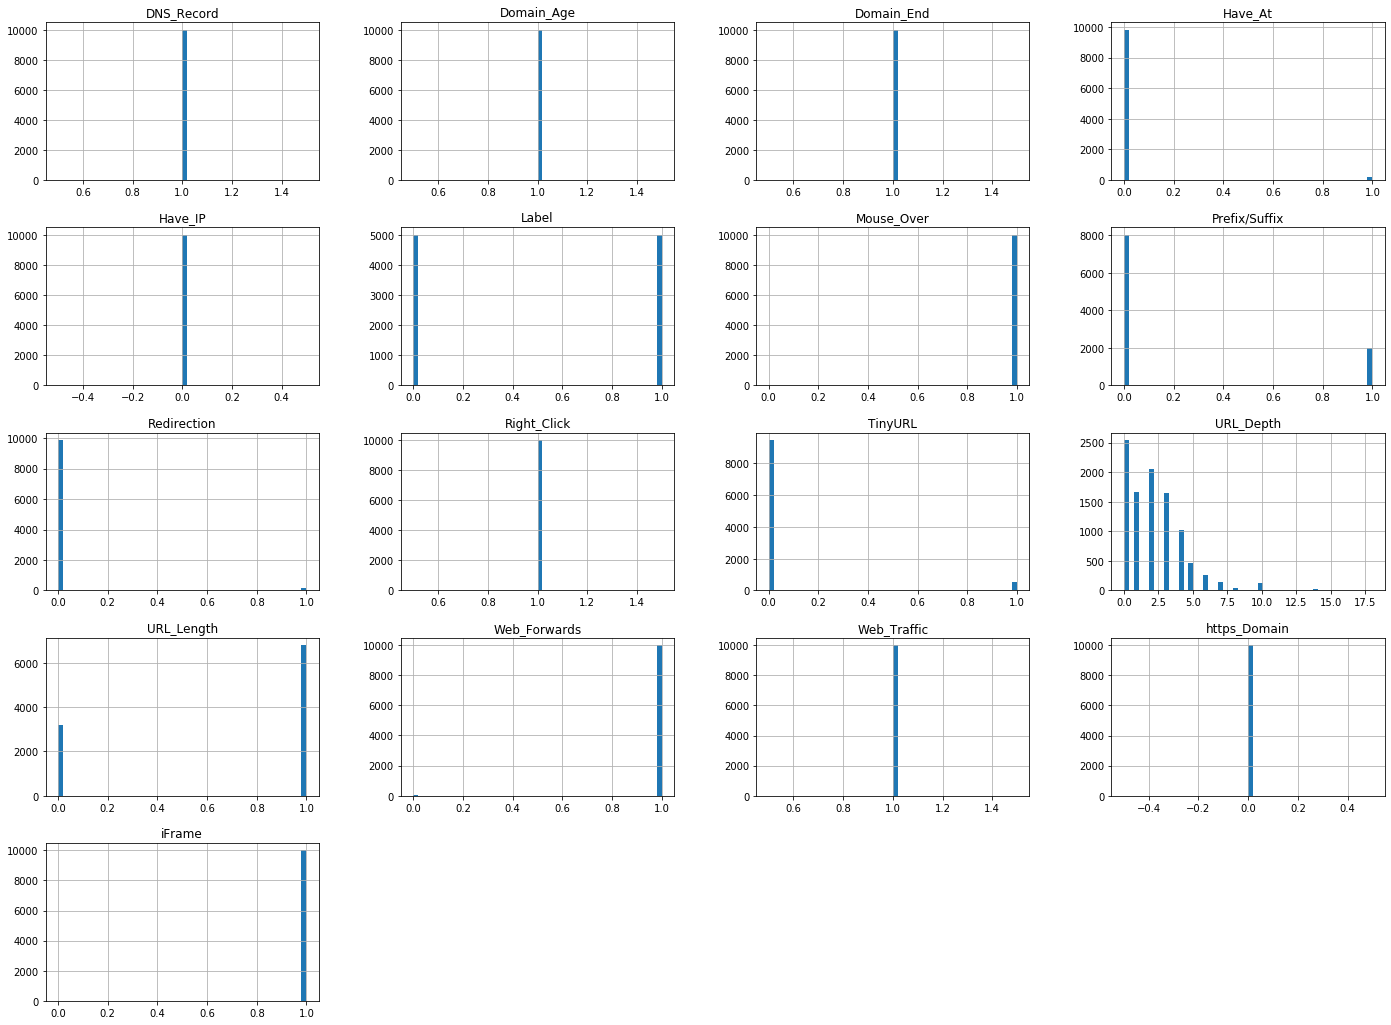

In [23]:
data.hist(bins = 50,figsize = (24,18))
plt.show()

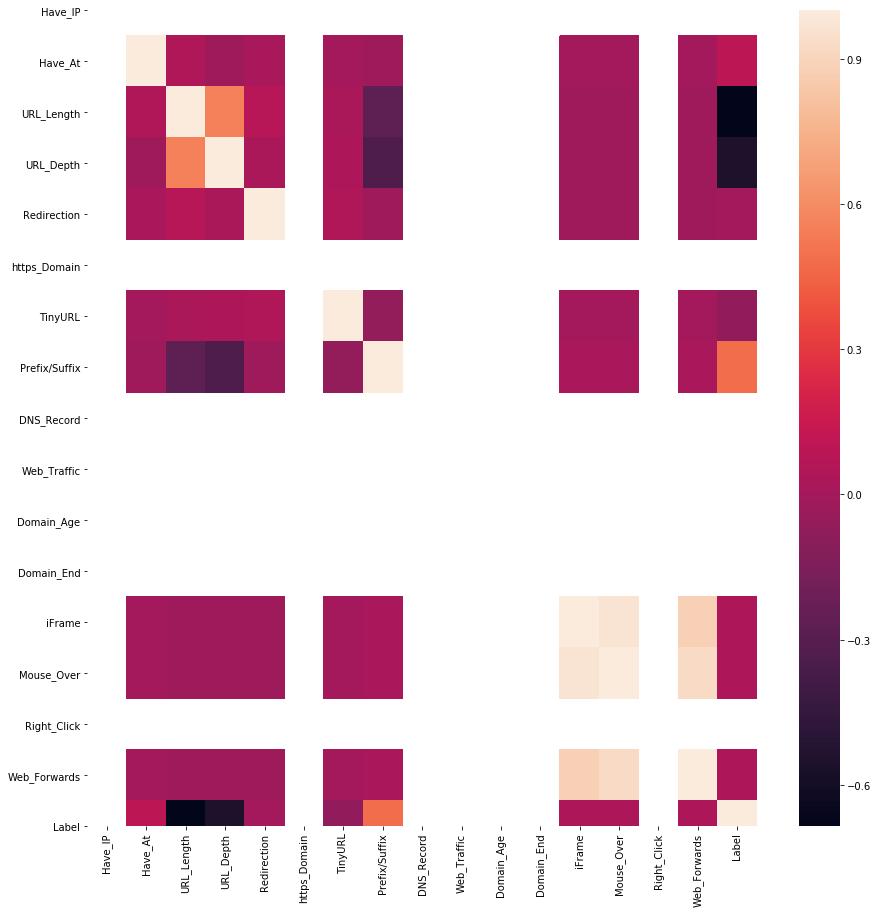

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr())
plt.show()

In [25]:
data.describe()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
count,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,0.0,0.019400,0.681100,2.171500,0.013200,0.0,0.053600,0.198600,1.0,1.0,1.0,1.0,0.998700,0.998600,1.0,0.998800,0.500000
std,0.0,0.137933,0.466074,2.065893,0.114136,0.0,0.225238,0.398966,0.0,0.0,0.0,0.0,0.036034,0.037392,0.0,0.034622,0.500025
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.000000,0.000000,1.0,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,0.000000
50%,0.0,0.000000,1.000000,2.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,0.500000
75%,0.0,0.000000,1.000000,3.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000
max,0.0,1.000000,1.000000,18.000000,1.000000,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000


In [26]:
data = data.drop(['Domain'], axis = 1)

In [27]:
data.isnull().sum()

Have_IP          0
Have_At          0
URL_Length       0
URL_Depth        0
Redirection      0
https_Domain     0
TinyURL          0
Prefix/Suffix    0
DNS_Record       0
Web_Traffic      0
Domain_Age       0
Domain_End       0
iFrame           0
Mouse_Over       0
Right_Click      0
Web_Forwards     0
Label            0
dtype: int64

# Algorithms

In [4]:
X = data.drop(['Label'], axis = 1)
y = data['Label']

NameError: name 'data' is not defined

In [2]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

NameError: name 'train_test_split' is not defined

# SVM

In [35]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)

SVC()

In [36]:
evaluate(svm,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3930   57]
 [ 600 3413]]
ACCURACY SCORE:
0.9179
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.867550     0.983573  0.917875     0.925562      0.925750
recall        0.985704     0.850486  0.917875     0.918095      0.917875
f1-score      0.922860     0.912201  0.917875     0.917531      0.917513
support    3987.000000  4013.000000  0.917875  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[1002   11]
 [ 136  851]]
ACCURACY SCORE:
0.9265
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.880492    0.987239    0.9265     0.933866      0.933172
recall        0.989141    0.862209    0.9265     0.925675      0.926500
f1-score      0.931660    0.920498    0.9265     0.926079      0.926151
support    1013.000000  987.000000    0.9265  2000.000000   2000.000000


In [37]:
y_pred = svm.predict(X_test)
a = accuracy_score(y_test, y_pred) * 100
p = precision_score(y_test,y_pred,average='macro') * 100 
r = recall_score(y_test,y_pred,average='macro') * 100
f = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a))
print("Precision: {:.2f}%".format(p))
print("Recall: {:.2f}%".format(r))
print("F1-score: {:.2f}%".format(f))
print("Sensitivity: {:.2f}%".format(sensitivity))
print("Specificity: {:.2f}%".format(specificity))

Accuracy: 92.65%
Precision: 93.39%
Recall: 92.57%
F1-score: 92.61%
Sensitivity: 86.22%
Specificity: 98.91%


# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [37]:
evaluate(rf,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3966   37]
 [1644 2353]]
ACCURACY SCORE:
0.7899
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.706952     0.984519  0.789875     0.845735      0.845631
recall        0.990757     0.588692  0.789875     0.789724      0.789875
f1-score      0.825133     0.736809  0.789875     0.780971      0.781004
support    4003.000000  3997.000000  0.789875  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[993   4]
 [430 573]]
ACCURACY SCORE:
0.7830
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.697822     0.993068     0.783     0.845445      0.845887
recall       0.995988     0.571286     0.783     0.783637      0.783000
f1-score     0.820661     0.725316     0.783     0.772989      0.772846
support    997.000000  1003.000000     0.783  2000.000000   2000.000000


In [38]:
y_pred = rf.predict(X_test)
a1 = accuracy_score(y_test, y_pred) * 100
p1 = precision_score(y_test,y_pred,average='macro') * 100 
r1 = recall_score(y_test,y_pred,average='macro') * 100
f1 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity1 = tp / (tp + fn) * 100
specificity1 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a1))
print("Precision: {:.2f}%".format(p1))
print("Recall: {:.2f}%".format(r1))
print("F1-score: {:.2f}%".format(f1))
print("Sensitivity: {:.2f}%".format(sensitivity1))
print("Specificity: {:.2f}%".format(specificity1))

Accuracy: 78.30%
Precision: 84.54%
Recall: 78.36%
F1-score: 77.30%
Sensitivity: 57.13%
Specificity: 99.60%


# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)

lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [40]:
evaluate(lr,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3799  204]
 [1345 2652]]
ACCURACY SCORE:
0.8064
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.738530     0.928571  0.806375     0.833551      0.833480
recall        0.949038     0.663498  0.806375     0.806268      0.806375
f1-score      0.830655     0.773968  0.806375     0.802311      0.802332
support    4003.000000  3997.000000  0.806375  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[940  57]
 [340 663]]
ACCURACY SCORE:
0.8015
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.734375     0.920833    0.8015     0.827604      0.827884
recall       0.942828     0.661017    0.8015     0.801923      0.801500
f1-score     0.825648     0.769588    0.8015     0.797618      0.797534
support    997.000000  1003.000000    0.8015  2000.000000   2000.000000


In [41]:
y_pred = lr.predict(X_test)
a2 = accuracy_score(y_test, y_pred) * 100
p2 = precision_score(y_test,y_pred,average='macro') * 100 
r2 = recall_score(y_test,y_pred,average='macro') * 100
f2 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity2 = tp / (tp + fn) * 100
specificity2 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a2))
print("Precision: {:.2f}%".format(p2))
print("Recall: {:.2f}%".format(r2))
print("F1-score: {:.2f}%".format(f2))
print("Sensitivity: {:.2f}%".format(sensitivity2))
print("Specificity: {:.2f}%".format(specificity2))

Accuracy: 80.15%
Precision: 82.76%
Recall: 80.19%
F1-score: 79.76%
Sensitivity: 66.10%
Specificity: 94.28%


# KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [43]:
evaluate(knn,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3731  272]
 [ 882 3115]]
ACCURACY SCORE:
0.8558
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.808801     0.919693   0.85575     0.864247      0.864205
recall        0.932051     0.779335   0.85575     0.855693      0.855750
f1-score      0.866063     0.843716   0.85575     0.854890      0.854898
support    4003.000000  3997.000000   0.85575  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[918  79]
 [258 745]]
ACCURACY SCORE:
0.8315
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.780612     0.904126    0.8315     0.842369      0.842555
recall       0.920762     0.742772    0.8315     0.831767      0.831500
f1-score     0.844915     0.815545    0.8315     0.830230      0.830186
support    997.000000  1003.000000    0.8315  2000.000000   2000.000000


In [44]:
y_pred = knn.predict(X_test)
a3 = accuracy_score(y_test, y_pred) * 100
p3 = precision_score(y_test,y_pred,average='macro') * 100 
r3 = recall_score(y_test,y_pred,average='macro') * 100
f3 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity3 = tp / (tp + fn) * 100
specificity3 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a3))
print("Precision: {:.2f}%".format(p3))
print("Recall: {:.2f}%".format(r3))
print("F1-score: {:.2f}%".format(f3))
print("Sensitivity: {:.2f}%".format(sensitivity3))
print("Specificity: {:.2f}%".format(specificity3))

Accuracy: 83.15%
Precision: 84.24%
Recall: 83.18%
F1-score: 83.02%
Sensitivity: 74.28%
Specificity: 92.08%


# Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(
    criterion='gini',       
    max_depth=10,           
    min_samples_split=5,     
    min_samples_leaf=2,     
    max_features='sqrt',    
    random_state=42,        
    class_weight=None,      
    splitter='best',        
    min_impurity_decrease=0, 
    ccp_alpha=0.0           
)

# Fit the DecisionTreeClassifier to your training data
dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, max_features='sqrt',
                       min_impurity_decrease=0, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)

In [46]:
evaluate(dt,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3753  250]
 [1259 2738]]
ACCURACY SCORE:
0.8114
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.748803     0.916332  0.811375     0.832567      0.832505
recall        0.937547     0.685014  0.811375     0.811280      0.811375
f1-score      0.832612     0.783966  0.811375     0.808289      0.808307
support    4003.000000  3997.000000  0.811375  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[934  63]
 [338 665]]
ACCURACY SCORE:
0.7995
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.734277     0.913462    0.7995     0.823869      0.824138
recall       0.936810     0.663011    0.7995     0.799911      0.799500
f1-score     0.823270     0.768342    0.7995     0.795806      0.795724
support    997.000000  1003.000000    0.7995  2000.000000   2000.000000


In [47]:
y_pred = dt.predict(X_test)
a4 = accuracy_score(y_test, y_pred) * 100
p4 = precision_score(y_test,y_pred,average='macro') * 100 
r4 = recall_score(y_test,y_pred,average='macro') * 100
f4 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity4 = tp / (tp + fn) * 100
specificity4 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a4))
print("Precision: {:.2f}%".format(p4))
print("Recall: {:.2f}%".format(r4))
print("F1-score: {:.2f}%".format(f4))
print("Sensitivity: {:.2f}%".format(sensitivity4))
print("Specificity: {:.2f}%".format(specificity4))

Accuracy: 79.95%
Precision: 82.39%
Recall: 79.99%
F1-score: 79.58%
Sensitivity: 66.30%
Specificity: 93.68%


# Adaboost

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

ada.fit(X_train, y_train)

AdaBoostClassifier()

In [49]:
evaluate(ada,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3558  445]
 [1088 2909]]
ACCURACY SCORE:
0.8084
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.765820     0.867323  0.808375     0.816571      0.816533
recall        0.888833     0.727796  0.808375     0.808315      0.808375
f1-score      0.822754     0.791457  0.808375     0.807106      0.807117
support    4003.000000  3997.000000  0.808375  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[886 111]
 [277 726]]
ACCURACY SCORE:
0.8060
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.761823     0.867384     0.806     0.814603      0.814762
recall       0.888666     0.723829     0.806     0.806247      0.806000
f1-score     0.820370     0.789130     0.806     0.804750      0.804704
support    997.000000  1003.000000     0.806  2000.000000   2000.000000


In [50]:
y_pred = ada.predict(X_test)
a5 = accuracy_score(y_test, y_pred) * 100
p5 = precision_score(y_test,y_pred,average='macro') * 100 
r5 = recall_score(y_test,y_pred,average='macro') * 100
f5 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity5 = tp / (tp + fn) * 100
specificity5 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a5))
print("Precision: {:.2f}%".format(p5))
print("Recall: {:.2f}%".format(r5))
print("F1-score: {:.2f}%".format(f5))
print("Sensitivity: {:.2f}%".format(sensitivity5))
print("Specificity: {:.2f}%".format(specificity5))

Accuracy: 80.60%
Precision: 81.46%
Recall: 80.62%
F1-score: 80.48%
Sensitivity: 72.38%
Specificity: 88.87%


# Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [52]:
evaluate(gnb,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3958   45]
 [1614 2383]]
ACCURACY SCORE:
0.7926
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.710337     0.981466  0.792625     0.845902      0.845800
recall        0.988758     0.596197  0.792625     0.792478      0.792625
f1-score      0.826736     0.741790  0.792625     0.784263      0.784295
support    4003.000000  3997.000000  0.792625  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[991   6]
 [416 587]]
ACCURACY SCORE:
0.7890
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.704335     0.989882     0.789     0.847109      0.847537
recall       0.993982     0.585244     0.789     0.789613      0.789000
f1-score     0.824459     0.735589     0.789     0.780024      0.779891
support    997.000000  1003.000000     0.789  2000.000000   2000.000000


In [53]:
y_pred = gnb.predict(X_test)
a6 = accuracy_score(y_test, y_pred) * 100
p6 = precision_score(y_test,y_pred,average='macro') * 100 
r6 = recall_score(y_test,y_pred,average='macro') * 100
f6 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity6 = tp / (tp + fn) * 100
specificity6 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a6))
print("Precision: {:.2f}%".format(p6))
print("Recall: {:.2f}%".format(r6))
print("F1-score: {:.2f}%".format(f6))
print("Sensitivity: {:.2f}%".format(sensitivity6))
print("Specificity: {:.2f}%".format(specificity6))

Accuracy: 78.90%
Precision: 84.71%
Recall: 78.96%
F1-score: 78.00%
Sensitivity: 58.52%
Specificity: 99.40%


# Gradient Boosting

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [55]:
evaluate(gb,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3909   94]
 [1234 2763]]
ACCURACY SCORE:
0.8340
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.760062     0.967098     0.834     0.863580      0.863503
recall        0.976518     0.691268     0.834     0.833893      0.834000
f1-score      0.854800     0.806245     0.834     0.830522      0.830540
support    4003.000000  3997.000000     0.834  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[974  23]
 [317 686]]
ACCURACY SCORE:
0.8300
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.754454     0.967560      0.83     0.861007      0.861327
recall       0.976931     0.683948      0.83     0.830439      0.830000
f1-score     0.851399     0.801402      0.83     0.826400      0.826325
support    997.000000  1003.000000      0.83  2000.000000   2000.000000


In [56]:
y_pred = gb.predict(X_test)
a7 = accuracy_score(y_test, y_pred) * 100
p7 = precision_score(y_test,y_pred,average='macro') * 100 
r7 = recall_score(y_test,y_pred,average='macro') * 100
f7 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity7 = tp / (tp + fn) * 100
specificity7 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a7))
print("Precision: {:.2f}%".format(p7))
print("Recall: {:.2f}%".format(r7))
print("F1-score: {:.2f}%".format(f7))
print("Sensitivity: {:.2f}%".format(sensitivity7))
print("Specificity: {:.2f}%".format(specificity7))

Accuracy: 83.00%
Precision: 86.10%
Recall: 83.04%
F1-score: 82.64%
Sensitivity: 68.39%
Specificity: 97.69%


# Xgboost

In [57]:
import xgboost as xgb

xg = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [58]:
evaluate(xg,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3730  273]
 [ 781 3216]]
ACCURACY SCORE:
0.8682
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.826868     0.921754   0.86825     0.874311      0.874275
recall        0.931801     0.804603   0.86825     0.868202      0.868250
f1-score      0.876204     0.859204   0.86825     0.867704      0.867710
support    4003.000000  3997.000000   0.86825  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[913  84]
 [211 792]]
ACCURACY SCORE:
0.8525
CLASSIFICATION REPORT:
                    0            1  accuracy    macro avg  weighted avg
precision    0.812278     0.904110    0.8525     0.858194      0.858331
recall       0.915747     0.789631    0.8525     0.852689      0.852500
f1-score     0.860915     0.843002    0.8525     0.851958      0.851931
support    997.000000  1003.000000    0.8525  2000.000000   2000.000000


In [59]:
y_pred = xg.predict(X_test)
a8 = accuracy_score(y_test, y_pred) * 100
p8 = precision_score(y_test,y_pred,average='macro') * 100 
r8 = recall_score(y_test,y_pred,average='macro') * 100
f8 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity8 = tp / (tp + fn) * 100
specificity8 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a8))
print("Precision: {:.2f}%".format(p8))
print("Recall: {:.2f}%".format(r8))
print("F1-score: {:.2f}%".format(f8))
print("Sensitivity: {:.2f}%".format(sensitivity8))
print("Specificity: {:.2f}%".format(specificity8))

Accuracy: 85.25%
Precision: 85.82%
Recall: 85.27%
F1-score: 85.20%
Sensitivity: 78.96%
Specificity: 91.57%


# CNN

In [60]:
X = data.drop(['Label'], axis = 1)
y = data['Label']


y_data = LabelBinarizer().fit_transform(y)

X=np.array(X)
y=np.array(y)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [62]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(2000, 16, 1)

In [63]:
model = Sequential() 
model.add(Conv1D(32, 3, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same", activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=50))
model.add(Dense(units=1,activation='softmax'))

In [64]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
125/125 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5015 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5015 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5015 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5015 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5015 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 6/10
125/125 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5015 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.5

In [65]:
y_pred = model.predict(X_test)  


y_pred_classes = np.argmax(y_pred, axis=1)


a9 = accuracy_score(y_test, y_pred_classes) * 100
p9 = precision_score(y_test, y_pred_classes, average='macro') * 100
r9 = recall_score(y_test, y_pred_classes, average='macro') * 100
f9 = f1_score(y_test, y_pred_classes, average='macro') * 100

conf_matrix = confusion_matrix(y_test, y_pred_classes)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]


sensitivity9 = TP / (TP + FN)* 100
specificity9 = TN / (TN + FP)* 100


print("Accuracy: {:.2f}%".format(a9))
print("Precision: {:.2f}%".format(p9))
print("Recall: {:.2f}%".format(r9))
print("F1-score: {:.2f}%".format(f9))
print("Sensitivity: {:.2f}%".format(sensitivity9))
print("Specificity: {:.2f}%".format(specificity9))

Accuracy: 50.60%
Precision: 25.30%
Recall: 50.00%
F1-score: 33.60%
Sensitivity: 0.00%
Specificity: 100.00%


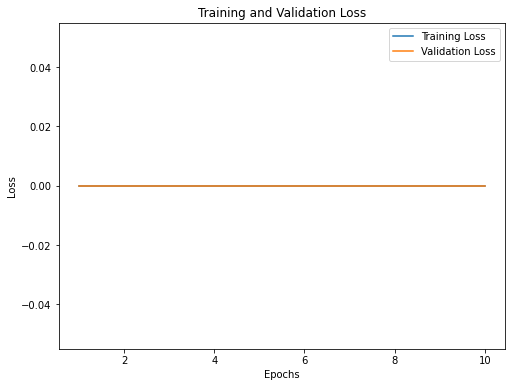

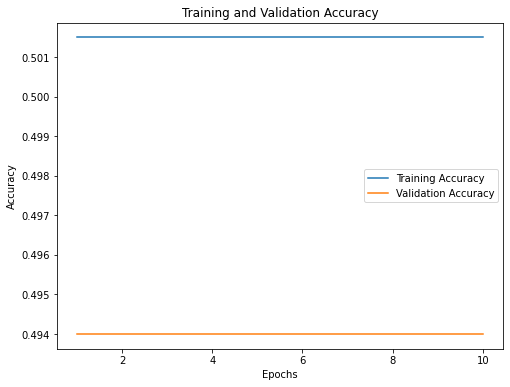

In [66]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# LSTM

In [67]:
X = data.drop(['Label'], axis = 1)
y = data['Label']



y_data = LabelBinarizer().fit_transform(y)

X=np.array(X)
y=np.array(y)



X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)
print(X_train.shape,'\n',X_test.shape)


X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))



y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

(8000, 16) 
 (2000, 16)


In [68]:
model = Sequential() 
model.add(LSTM(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))

model.add(Dense(units=2,activation='softmax'))

In [69]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
125/125 [==============================] - 2s 9ms/step - loss: 0.5609 - accuracy: 0.7071 - val_loss: 0.4419 - val_accuracy: 0.7955
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4241 - accuracy: 0.7976 - val_loss: 0.4155 - val_accuracy: 0.7895
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4163 - accuracy: 0.8044 - val_loss: 0.4110 - val_accuracy: 0.8070
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4085 - accuracy: 0.8081 - val_loss: 0.4052 - val_accuracy: 0.8140
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4024 - accuracy: 0.8094 - val_loss: 0.4026 - val_accuracy: 0.8170
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4011 - accuracy: 0.8129 - val_loss: 0.4065 - val_accuracy: 0.8080
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.3961 - accuracy: 0.8120 - val_loss: 0.3961 - val_accuracy: 0.8170
Epoch 

In [70]:
y_pred_lstm = model.predict(X_test)  
y_test = np.argmax(y_test, axis=1)

y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)


a10 = accuracy_score(y_test, y_pred_lstm_classes) * 100
p10 = precision_score(y_test, y_pred_lstm_classes, average='macro') * 100
r10 = recall_score(y_test, y_pred_lstm_classes, average='macro') * 100
f10 = f1_score(y_test, y_pred_lstm_classes, average='macro') * 100

conf_matrix_gru = confusion_matrix(y_test, y_pred_lstm_classes)

TN = conf_matrix_gru[0, 0]
FP = conf_matrix_gru[0, 1]
FN = conf_matrix_gru[1, 0]
TP = conf_matrix_gru[1, 1]


sensitivity10 = TP / (TP + FN)* 100
specificity10 = TN / (TN + FP)* 100


print("Accuracy: {:.2f}%".format(a10))
print("Precision: {:.2f}%".format(p10))
print("Recall: {:.2f}%".format(r10))
print("F1-score: {:.2f}%".format(f10))
print("Sensitivity: {:.2f}%".format(sensitivity10))
print("Specificity: {:.2f}%".format(specificity10))

Accuracy: 80.35%
Precision: 81.45%
Recall: 80.24%
F1-score: 80.13%
Sensitivity: 70.75%
Specificity: 89.72%


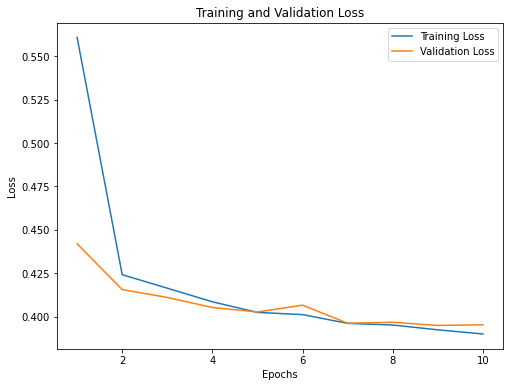

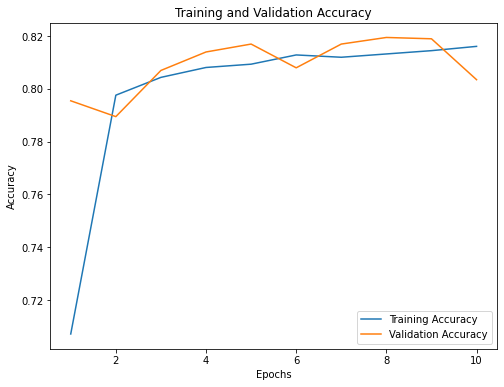

In [71]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Deep Neural Network

In [72]:
X = data.drop(['Label'], axis = 1)
y = data['Label']



y_data = LabelBinarizer().fit_transform(y)

X=np.array(X)
y=np.array(y)



X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)
print(X_train.shape,'\n',X_test.shape)


X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))



y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

(8000, 16) 
 (2000, 16)


In [73]:
model = Sequential() 
model.add(SimpleRNN(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))
model.add(Dense(units=2,activation='softmax'))

In [74]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 0.5251 - accuracy: 0.7329 - val_loss: 0.4302 - val_accuracy: 0.7950
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4481 - accuracy: 0.7836 - val_loss: 0.4303 - val_accuracy: 0.8005
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4332 - accuracy: 0.7929 - val_loss: 0.4142 - val_accuracy: 0.7780
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.7999 - val_loss: 0.4102 - val_accuracy: 0.7910
Epoch 5/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4174 - accuracy: 0.7989 - val_loss: 0.4175 - val_accuracy: 0.7960
Epoch 6/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4136 - accuracy: 0.8061 - val_loss: 0.4054 - val_accuracy: 0.7845
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.4040 - accuracy: 0.8051 - val_loss: 0.3994 - val_accuracy: 0.8100
Epoch 

In [75]:
y_pred_rnn = model.predict(X_test)  
y_test = np.argmax(y_test, axis=1)

y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)


a11 = accuracy_score(y_test, y_pred_rnn_classes) * 100
p11 = precision_score(y_test, y_pred_rnn_classes, average='macro') * 100
r11 = recall_score(y_test, y_pred_rnn_classes, average='macro') * 100
f11 = f1_score(y_test, y_pred_rnn_classes, average='macro') * 100

conf_matrix_gru = confusion_matrix(y_test, y_pred_rnn_classes)

TN = conf_matrix_gru[0, 0]
FP = conf_matrix_gru[0, 1]
FN = conf_matrix_gru[1, 0]
TP = conf_matrix_gru[1, 1]


sensitivity11 = TP / (TP + FN)* 100
specificity11 = TN / (TN + FP)* 100

print("Accuracy: {:.2f}%".format(a11))
print("Precision: {:.2f}%".format(p11))
print("Recall: {:.2f}%".format(r11))
print("F1-score: {:.2f}%".format(f11))
print("Sensitivity: {:.2f}%".format(sensitivity11))
print("Specificity: {:.2f}%".format(specificity11))

Accuracy: 81.55%
Precision: 85.69%
Recall: 81.35%
F1-score: 80.93%
Sensitivity: 64.27%
Specificity: 98.42%


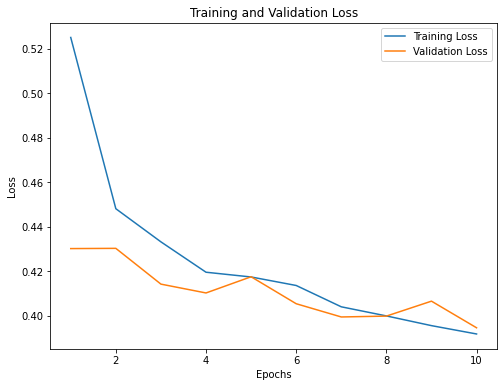

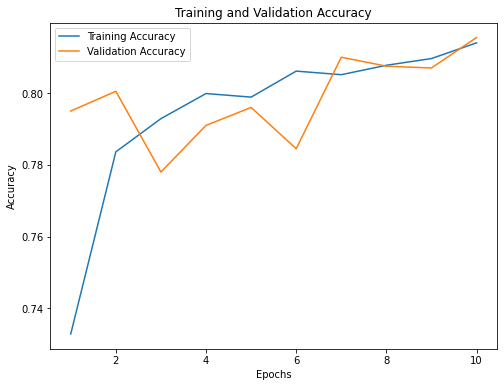

In [76]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# MLP

In [77]:
X = data.drop(['Label'], axis = 1)
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

mlp.fit(X_train, y_train)

MLPClassifier()

In [78]:
evaluate(mlp,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3851  137]
 [1015 2997]]
ACCURACY SCORE:
0.8560
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.791410     0.956286     0.856     0.873848      0.874095
recall        0.965647     0.747009     0.856     0.856328      0.856000
f1-score      0.869889     0.838791     0.856     0.854340      0.854293
support    3988.000000  4012.000000     0.856  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[988  24]
 [281 707]]
ACCURACY SCORE:
0.8475
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.778566    0.967168    0.8475     0.872867      0.871735
recall        0.976285    0.715587    0.8475     0.845936      0.847500
f1-score      0.866287    0.822571    0.8475     0.844429      0.844691
support    1012.000000  988.000000    0.8475  2000.000000   2000.000000


In [79]:
y_pred = mlp.predict(X_test)
a12 = accuracy_score(y_test, y_pred) * 100
p12 = precision_score(y_test,y_pred,average='macro') * 100 
r12 = recall_score(y_test,y_pred,average='macro') * 100
f12 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity12 = tp / (tp + fn) * 100
specificity12 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a12))
print("Precision: {:.2f}%".format(p12))
print("Recall: {:.2f}%".format(r12))
print("F1-score: {:.2f}%".format(f12))
print("Sensitivity: {:.2f}%".format(sensitivity12))
print("Specificity: {:.2f}%".format(specificity12))

Accuracy: 84.75%
Precision: 87.29%
Recall: 84.59%
F1-score: 84.44%
Sensitivity: 71.56%
Specificity: 97.63%


## Perceptron

In [80]:
from sklearn.linear_model import Perceptron

pre = Perceptron(tol=1e-3, random_state=0)

pre.fit(X_train, y_train)

Perceptron()

In [81]:
evaluate(pre,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3184  804]
 [ 955 3057]]
ACCURACY SCORE:
0.7801
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.769268     0.791764  0.780125     0.780516      0.780550
recall        0.798395     0.761964  0.780125     0.780180      0.780125
f1-score      0.783561     0.776578  0.780125     0.780070      0.780059
support    3988.000000  4012.000000  0.780125  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[805 207]
 [270 718]]
ACCURACY SCORE:
0.7615
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.748837    0.776216    0.7615     0.762527      0.762362
recall        0.795455    0.726721    0.7615     0.761088      0.761500
f1-score      0.771442    0.750653    0.7615     0.761048      0.761173
support    1012.000000  988.000000    0.7615  2000.000000   2000.000000


In [82]:
y_pred = pre.predict(X_test)
a13 = accuracy_score(y_test, y_pred) * 100
p13 = precision_score(y_test,y_pred,average='macro') * 100 
r13 = recall_score(y_test,y_pred,average='macro') * 100
f13 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity13 = tp / (tp + fn) * 100
specificity13 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a13))
print("Precision: {:.2f}%".format(p13))
print("Recall: {:.2f}%".format(r13))
print("F1-score: {:.2f}%".format(f13))
print("Sensitivity: {:.2f}%".format(sensitivity13))
print("Specificity: {:.2f}%".format(specificity13))

Accuracy: 76.15%
Precision: 76.25%
Recall: 76.11%
F1-score: 76.10%
Sensitivity: 72.67%
Specificity: 79.55%


# Passive Aggressive Classifier

In [83]:
from sklearn.linear_model import PassiveAggressiveClassifier

passive = PassiveAggressiveClassifier()

passive.fit(X_train, y_train)

PassiveAggressiveClassifier()

In [84]:
evaluate(passive,X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[  54 3934]
 [  18 3994]]
ACCURACY SCORE:
0.5060
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.750000     0.503784     0.506     0.626892      0.626523
recall        0.013541     0.995513     0.506     0.504527      0.506000
f1-score      0.026601     0.669012     0.506     0.347806      0.348770
support    3988.000000  4012.000000     0.506  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[ 15 997]
 [  7 981]]
ACCURACY SCORE:
0.4980
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.681818    0.495956     0.498     0.588887      0.590002
recall        0.014822    0.992915     0.498     0.503869      0.498000
f1-score      0.029014    0.661497     0.498     0.345255      0.341460
support    1012.000000  988.000000     0.498  2000.000000   2000.000000


In [85]:
y_pred = passive.predict(X_test)
a14 = accuracy_score(y_test, y_pred) * 100
p14 = precision_score(y_test,y_pred,average='macro') * 100 
r14 = recall_score(y_test,y_pred,average='macro') * 100
f14 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity14 = tp / (tp + fn) * 100
specificity14 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a14))
print("Precision: {:.2f}%".format(p14))
print("Recall: {:.2f}%".format(r14))
print("F1-score: {:.2f}%".format(f14))
print("Sensitivity: {:.2f}%".format(sensitivity14))
print("Specificity: {:.2f}%".format(specificity14))

Accuracy: 49.80%
Precision: 58.89%
Recall: 50.39%
F1-score: 34.53%
Sensitivity: 99.29%
Specificity: 1.48%


# Voting Classifier 

In [86]:
from sklearn.ensemble import VotingClassifier


clf1 = MLPClassifier()
clf2 = xgb.XGBClassifier()
clf3 = DecisionTreeClassifier()

eclf11 = VotingClassifier(estimators=[('mlp', clf1), ('xg', clf2), ('dt', clf3)], voting='hard')



eclf11.fit(X_train, y_train)



VotingClassifier(estimators=[('mlp', MLPClassifier()),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=N

In [87]:
evaluate(eclf11, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3793  195]
 [ 873 3139]]
ACCURACY SCORE:
0.8665
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.812902     0.941512    0.8665     0.877207      0.877400
recall        0.951103     0.782403    0.8665     0.866753      0.866500
f1-score      0.876589     0.854615    0.8665     0.865602      0.865569
support    3988.000000  4012.000000    0.8665  8000.000000   8000.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[976  36]
 [251 737]]
ACCURACY SCORE:
0.8565
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.795436    0.953428    0.8565     0.874432      0.873484
recall        0.964427    0.745951    0.8565     0.855189      0.856500
f1-score      0.871818    0.837024    0.8565     0.854421      0.854630
support    1012.000000  988.000000    0.8565  2000.000000   2000.000000


In [88]:
y_pred = eclf11.predict(X_test)
a15 = accuracy_score(y_test, y_pred) * 100
p15 = precision_score(y_test,y_pred,average='macro') * 100 
r15 = recall_score(y_test,y_pred,average='macro') * 100
f15 = f1_score(y_test,y_pred,average='macro') * 100
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity15 = tp / (tp + fn) * 100
specificity15 = tn / (tn + fp) * 100


print("Accuracy: {:.2f}%".format(a15))
print("Precision: {:.2f}%".format(p15))
print("Recall: {:.2f}%".format(r15))
print("F1-score: {:.2f}%".format(f15))
print("Sensitivity: {:.2f}%".format(sensitivity15))
print("Specificity: {:.2f}%".format(specificity15))

Accuracy: 85.65%
Precision: 87.44%
Recall: 85.52%
F1-score: 85.44%
Sensitivity: 74.60%
Specificity: 96.44%


# Comparison

In [89]:
results = {
    'accuracy': [a, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15],
    'precision': [p, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15],
    'f1': [f, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15],
    'recall': [r, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15],
    'sensitivity': [sensitivity, sensitivity1, sensitivity2, sensitivity3, sensitivity4, sensitivity5, sensitivity6, sensitivity7, sensitivity8, sensitivity9, sensitivity10, sensitivity11, sensitivity12, sensitivity13, sensitivity14, sensitivity15],
    'specificity': [specificity, specificity1, specificity2, specificity3, specificity4, specificity5, specificity6, specificity7, specificity8, specificity9, specificity10, specificity11, specificity12, specificity13, specificity14, specificity15],

}

index = ['SVM','Random Forest','Logistic Regression','KNN','Decision Tree','Adaboost','Naive Bayes','Gradient Boosting','Xgboost','CNN','LSTM','Deep Neural Network','MLP','Perceptron','Passive Aggressive','Voting Classifier']


In [90]:
results =pd.DataFrame(results,index=index)

In [91]:
print(results)

                     accuracy  precision         f1     recall  sensitivity  \
SVM                     82.05  85.508906  81.616852  82.096789    66.500499   
Random Forest           78.30  84.544455  77.298881  78.363705    57.128614   
Logistic Regression     80.15  82.760417  79.761786  80.192272    66.101695   
KNN                     83.15  84.236923  83.022974  83.176699    74.277168   
Decision Tree           79.95  82.386913  79.580608  79.991070    66.301097   
Adaboost                80.60  81.460319  80.475040  80.624726    72.382851   
Naive Bayes             78.90  84.710871  78.002410  78.961311    58.524427   
Gradient Boosting       83.00  86.100693  82.640024  83.043947    68.394816   
Xgboost                 85.25  85.819358  85.195813  85.268917    78.963111   
CNN                     50.60  25.300000  33.598938  50.000000     0.000000   
LSTM                    80.35  81.452438  80.133048  80.236154    70.748988   
Deep Neural Network     81.55  85.687356  80.928651 

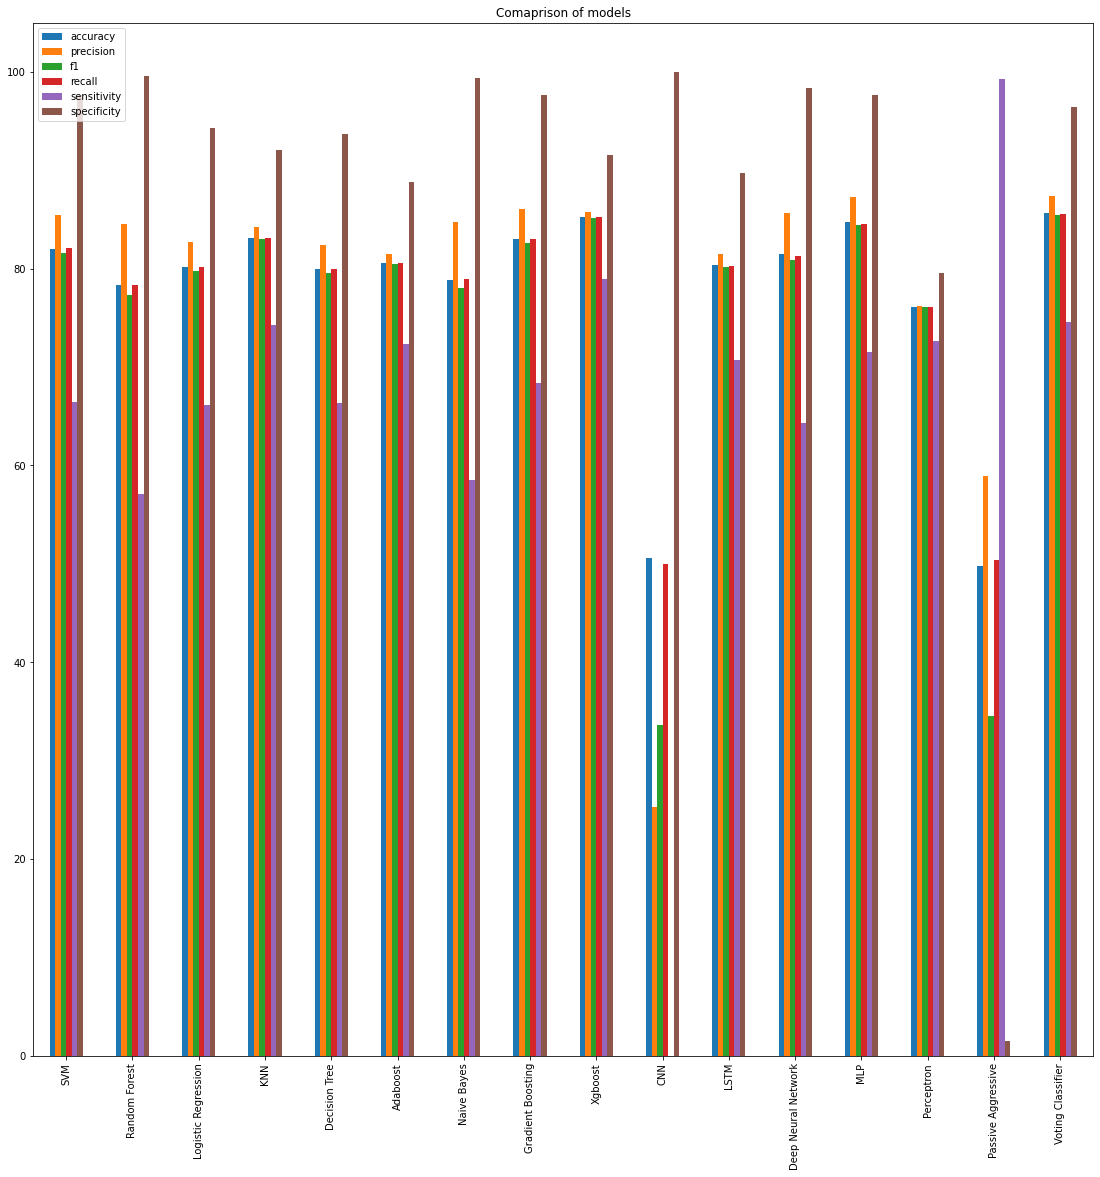

In [92]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

# Saving Model

In [93]:
pickle.dump(eclf11,open('model.sav','wb'))